# EchoPro Python Workflow <a class="tocSkip">

# Import libraries and configure the Jupyter notebook

In [1]:
import matplotlib.pyplot as plt

# Python EchoPro
import EchoPro

# Allows us to grab the SemiVariogram class so we can use its models
from EchoPro.computation import SemiVariogram as SV

# obtain all visualization routines
from EchoPro.visualization import plot_layered_points, plot_kriging_results

# Allows us to easily use matplotlib widgets in our Notebook
%matplotlib widget

EchoPro.__version__

'0.1.0-alpha'

# Set up  EchoPro for a specific survey year

## Initialize EchoPro object  using configuration files

* `initialization_config.yml` -- parameters independent of survey year
* `survey_year_2019_config.yml` -- parameters specific to survey year
* `source` -- Define the region of data to use e.g. US, CAN, US & CAN
* `exclude_age1` -- States whether age 1 hake should be included in analysis.

In [2]:
%%time
survey_2019 = EchoPro.Survey(init_file_path='../config_files/initialization_config.yml',
                             survey_year_file_path='../config_files/survey_year_2019_config.yml',
                             source=3, 
                             exclude_age1=True)

A full check of the initialization file contents needs to be done!
A check of the survey year file contents needs to be done!
CPU times: user 3.27 ms, sys: 6.07 ms, total: 9.34 ms
Wall time: 9.19 ms


## Load and process input data 
* This data is stored in `survey_2019`

In [3]:
%%time 
survey_2019.load_survey_data() #file_type='biological')

CPU times: user 1.35 s, sys: 1.1 ms, total: 1.35 s
Wall time: 1.39 s


In [4]:
survey_2019.specimen_df.head()

sex  length  weight  age
haul_num                          
1           1    24.0    0.08  1.0
1           1    23.0    0.06  1.0
1           1    22.0    0.06  1.0
1           1    21.0    0.06  1.0
1           2    22.0    0.06  1.0

## Compute the areal biomass density
* The areal biomass density is stored in `survey_2019`

In [5]:
%%time
survey_2019.compute_biomass_density()

CPU times: user 361 ms, sys: 4.61 ms, total: 366 ms
Wall time: 368 ms


In [6]:
survey_2019.bio_calc.final_biomass_table.head()

latitude   longitude  stratum_num  transect_spacing  \
transect_num                                                         
1             34.397267 -121.143005            1              10.0   
1             34.397391 -121.133196            1              10.0   
1             34.397435 -121.123057            1              10.0   
1             34.397394 -121.112871            1              10.0   
1             34.397437 -121.102888            1              10.0   

              areal_biomass_density_adult                     geometry  
transect_num                                                            
1                                     0.0  POINT (-121.14301 34.39727)  
1                                     0.0  POINT (-121.13320 34.39739)  
1                                     0.0  POINT (-121.12306 34.39744)  
1                                     0.0  POINT (-121.11287 34.39739)  
1                                     0.0  POINT (-121.10289 34.39744)

# Jolly-Hampton CV Analysis

* Compute the mean of the Jolly-Hampton CV value on data that has not been Kriged
* Note: the algorithm used to compute this value is random in nature

In [7]:
%%time
CV_JH_mean = survey_2019.run_cv_analysis(kriged_data=False)

CPU times: user 1.32 s, sys: 16.5 ms, total: 1.34 s
Wall time: 1.36 s


In [8]:
print(f"Mean Jolly-Hampton CV: {CV_JH_mean:.4f}")

Mean Jolly-Hampton CV: 0.1338


# Obtain Kriging Mesh Data

## Access Kriging mesh object
* Reads mesh data files specified by `survey_2019` 

In [9]:
krig_mesh = survey_2019.get_kriging_mesh()

### Plot the transects and smoothed isobath contour, and optionally the mesh points

* `plot_layered_points` generates an interactive map using the Folium package
* Transect points are represented by a changing color gradient
* Smoothed contour points (200m isobath) are in blue 
* Here we choose not to plot the mesh points to prevent this notebook from getting too big. To plot the mesh points, omit the `plot_mesh_points` argument or use `plot_mesh_points=True`. Mesh points will be in gray

In [10]:
fmap = plot_layered_points(krig_mesh, plot_mesh_points=False)
fmap

## Apply coordinate transformations
* Longitude transformation
* Lat/Lon to distance

### Transect points

In [11]:
krig_mesh.apply_coordinate_transformation(coord_type='transect')

### Mesh points

In [12]:
krig_mesh.apply_coordinate_transformation(coord_type='mesh')

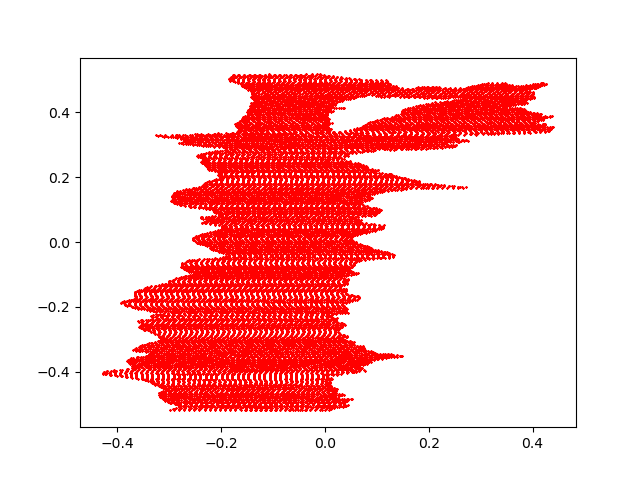

In [13]:
# plot the transformed mesh points 
plt.plot(krig_mesh.transformed_mesh_df.x_mesh, 
         krig_mesh.transformed_mesh_df.y_mesh, 'r*', markersize=1.25)
plt.show()

# Compute biomass density Semi-Variogram and fit a model

* Compute the normalized semi-variogram using the areal biomass density
* Fit a model to the semi-variogram values

## Compute the semi-variogram

### Initialize semi-variogram calculation
* Transformed transect points
* Parameters specific to semi-variogram algorithm

In [14]:
semi_vario = survey_2019.get_semi_variogram(
    krig_mesh,
    params=dict(nlag=30, lag_res=0.002)
)

### Compute the normalized semi-variogram

In [15]:
%%time
semi_vario.calculate_semi_variogram()

CPU times: user 4.1 s, sys: 2.6 s, total: 6.7 s
Wall time: 3.97 s


## Fit a model to the semi-variogram

* A widget to easily fit the model

In [16]:
semi_vario.get_widget()

GridspecLayout(children=(Dropdown(description='Semi-variogram model', index=1, layout=Layout(grid_area='widget…

# Perform Ordinary Kriging of biomass density

* transformed mesh points
* semi-variogram model
* areal biomass density 

## Initialize Kriging routine

In [17]:
kriging_params = dict(
    # kriging parameters
    k_max=10,
    k_min=3,
    R=0.0226287,
    ratio=0.001,
    
    # parameters for semi-variogram model
    s_v_params={'nugget': 0.0, 'sill': 0.95279, 'ls': 0.0075429,
                'exp_pow': 1.5, 'ls_hole_eff': 0.0},
    
    # grab appropriate semi-variogram model
    s_v_model=SV.generalized_exp_bessel
)

# uncomment to use widget values 
# kriging_params.update(semi_vario.get_params_for_kriging())

# initalize kriging routine
krig = survey_2019.get_kriging(kriging_params)

## Perform Kriging
* Also generates total biomass at mesh points

In [18]:
%%time
krig.run_biomass_kriging(krig_mesh)

CPU times: user 4.77 s, sys: 3.87 s, total: 8.64 s
Wall time: 4.14 s


In [19]:
krig_results = survey_2019.bio_calc.krig_results_gdf

kmt = $10^3$ metric tons = $10^6$ kg

In [20]:
print(f"Total Kriged Biomass Estimate: {1e-6*krig_results.krig_biomass_vals.sum():.3f} kmt")

Total Kriged Biomass Estimate: 1725.033 kmt


## Plot Kriged Biomass estimate in kmt

Here we use the argument `greater_than_0=True` to limit the mesh biomass points that are plotted to ones with biomass value > 0, to prevent this notebook from getting too big. To plot all mesh points, omit the `greater_than_0` argument or use `greater_than_0=False`.

In [21]:
krig_results.krig_biomass_vals = 1e-6 * krig_results.krig_biomass_vals
plot_kriging_results(krig_results, krig_field_name="krig_biomass_vals", greater_than_0=True)